In [ ]:
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [ ]:
!pip install pandas seaborn

In [ ]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import precision_recall_curve
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import resized_crop
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import timm
import random
from collections import Counter


In [ ]:
# Setup
def setup_environment():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

In [ ]:
def create_balanced_subset(dataset):
    class_to_idx = dataset.class_to_idx
    normal_idx = [i for i, (_, label) in enumerate(dataset) if label == class_to_idx['NORMAL']]
    pneumonia_idx = [i for i, (_, label) in enumerate(dataset) if label == class_to_idx['PNEUMONIA']]

    # Match pneumonia to normal count
    pneumonia_sampled_idx = random.sample(pneumonia_idx, len(normal_idx))
    balanced_indices = normal_idx + pneumonia_sampled_idx
    random.shuffle(balanced_indices)

    return Subset(dataset, balanced_indices)

In [ ]:
class ClassSpecificTransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform_normal, transform_other):
        self.dataset = dataset
        self.transform_normal = transform_normal
        self.transform_other = transform_other

        # If dataset is a Subset, use its parent to get class_to_idx
        if isinstance(dataset, torch.utils.data.Subset):
            self.class_to_idx = dataset.dataset.class_to_idx
        else:
            self.class_to_idx = dataset.class_to_idx

        self.normal_class_idx = self.class_to_idx['NORMAL']

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if label == self.normal_class_idx:
            img = self.transform_normal(img)
        else:
            img = self.transform_other(img)
        return img, label

    def __len__(self):
        return len(self.dataset)



In [ ]:
def get_classes(dataset):
    if hasattr(dataset, 'classes'):
        # print("Dataset has a 'classes' attribute.")
        return dataset.classes
    elif hasattr(dataset, 'dataset'):
        # print("Dataset has a 'dataset' attribute. Please use get_classes(dataset.dataset) instead.")
        return get_classes(dataset.dataset)
    else:
        raise AttributeError("Could not find 'classes' attribute in the dataset.")


In [ ]:

def data_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [ ]:
def load_data(data_dir, data_balancing=False):
    transform_other = data_transforms()

    # Stronger augmentations for NORMAL class
    transform_normal = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.4, contrast=0.4),
        transforms.RandomAffine(15),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])

    # Always load full original training set for weight calculation
    placeholder_transform = transforms.Lambda(lambda x: x)

    full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), placeholder_transform)

    # Compute class weights BEFORE any sampling
    original_targets = full_train_dataset.targets
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(original_targets), y=original_targets)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Apply undersampling
    if data_balancing:
        train_dataset = create_balanced_subset(full_train_dataset)
    else:
        train_dataset = full_train_dataset

    train_dataset = ClassSpecificTransformDataset(train_dataset, transform_normal, transform_other)
    # Load other sets
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform_other)
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform_other)

    image_datasets = {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset
    }

    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=4, shuffle=True)
        for x in ['train', 'val', 'test']
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = val_dataset.classes  # consistent with all datasets

    return image_datasets, dataloaders, dataset_sizes, class_names, class_weights

In [ ]:
def show_data_distribution(image_datasets):
    # Extract labels from the Subset
    labels = [image_datasets['train'][i][1] for i in range(len(image_datasets['train']))]
    label_counts = pd.Series(labels).value_counts()

    class_names = get_classes(image_datasets['train'])
    # Bar plot
    sns.barplot(x=[class_names[i] for i in label_counts.index], y=label_counts.values)
    plt.title('Class Distribution')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.show()

    # Pie plot
    plt.pie(label_counts.values, labels=[class_names[i] for i in label_counts.index], autopct='%1.1f%%')
    plt.title('Class Proportion')
    plt.show()


In [ ]:
# Visualize samples
def visualize_samples(dataloader, class_names, label_filter=None):
    counter = 0
    fig, axes = plt.subplots(2, 6, figsize=(12, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for inputs, labels in dataloader:
        for img, label in zip(inputs, labels):
            if label_filter is None or label.item() == label_filter:
                img = img.numpy().transpose((1, 2, 0))
                img = np.clip(img * np.array([0.229, 0.224, 0.225]) +
                              np.array([0.485, 0.456, 0.406]), 0, 1)
                axes[counter // 6, counter % 6].imshow(img)
                axes[counter // 6, counter % 6].set_title(class_names[label.item()])
                axes[counter // 6, counter % 6].axis('off')
                counter += 1
                if counter == 12:
                    plt.suptitle('Sample Images')
                    plt.show()
                    return

In [ ]:
def train_model(model, dataloaders, device, class_weights=None,USE_FOCAL_LOSS=True,num_epochs=10,gamma=2.0):
    # Setup loss function with class weights if provided
    lr=0.001
    USE_FOCAL_LOSS = True
    if USE_FOCAL_LOSS:
        criterion = FocalLoss(gamma=gamma, weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

    model = model.to(device)

    # Metrics tracking
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # --- Training ---
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = running_loss / len(dataloaders['train'])
        train_acc = correct_train / total_train
        train_losses.append(avg_loss)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(dataloaders['val'])
        val_acc = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        # Adjust learning rate
        scheduler.step(avg_val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return model, train_losses, val_losses, val_accuracies


In [ ]:
# Model Evaluator
def evaluate_model(model, dataloaders, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names)

    # Confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Class-wise accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.bar(class_names, class_acc, color='skyblue')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 1)
    plt.show()

    print("Classification Report:\n", cr)

In [ ]:
def evaluate_classwise_accuracy(model, dataloader, device, class_names):
    model.eval()
    num_classes = len(class_names)
    correct = [0] * num_classes
    total = [0] * num_classes

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for label, pred in zip(labels, preds):
                total[label] += 1
                if label == pred:
                    correct[label] += 1

    classwise_accuracy = [c / t if t > 0 else 0.0 for c, t in zip(correct, total)]
   

In [ ]:
# Plot Training Loss
def plot_metrics(train_losses, val_losses, model_name):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()



In [ ]:
class ConvNeXtV2Modified(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNeXtV2Modified, self).__init__()
        self.model = timm.create_model('convnextv2_base', pretrained=True)
        self.model.head = nn.Identity()
        self.model = self.model.to(device)
        self._get_fc_input_size()
        self.fc = nn.Linear(self.fc_input_size, num_classes)

    def _get_fc_input_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224).to(device)
            dummy_output = self.model.forward_features(dummy_input)
            self.fc_input_size = dummy_output.reshape(1, -1).size(1)


    def forward(self, x):
        x = self.model.forward_features(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
# Load Specific Models
def get_model(model_name, num_classes):
    if model_name == 'resnet':
        model = torchvision.models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'resnext':
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'resnest':
        model = timm.create_model('resnest50d', pretrained=True)
        model.fc = nn.Linear(model.get_classifier().in_features, num_classes)
    elif model_name == 'convnextv2':
        model = ConvNeXtV2Modified(num_classes=2).to(device)
    else:
        raise ValueError("Unknown model name")
    return model

In [ ]:


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        """
        gamma: focusing parameter. Higher values focus more on hard examples.
        weight: class weights (tensor of shape [num_classes])
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        focal_term = (1 - probs) ** self.gamma
        focal_loss = -focal_term * log_probs
        return torch.mean(torch.sum(focal_loss * self.weight[targets].unsqueeze(1), dim=1))


In [ ]:
# Setup environment
device = setup_environment()


Using device: cuda:0


In [ ]:
# Load data
data_dir = "thesis/input/chest-xray-pneumonia/chest_xray"
image_datasets, dataloaders, dataset_sizes, class_names,class_weights = load_data(data_dir)



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


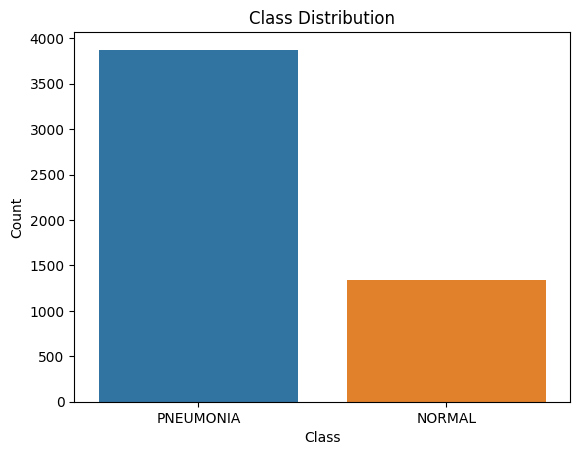

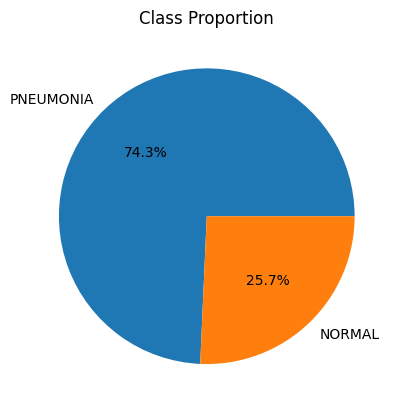

In [ ]:
show_data_distribution(image_datasets)

In [ ]:

# data_dir = "/content/drive/MyDrive/chest_xray"
image_datasets, dataloaders, dataset_sizes, class_names, class_weights = load_data(data_dir, data_balancing=True)
print("Unbalanced Class Weights:", class_weights)
class_weights = torch.tensor([1.5, 0.8])
print("Adjusted Class Weights:",class_weights)
class_weights = class_weights.to(device)
# # Check class distribution

print("Balanced Class Distribution:")
targets = [image_datasets['train'][i][1] for i in range(len(image_datasets['train']))]
class_names = get_classes(image_datasets['train'])
counts = Counter(targets)
for idx in range(len(counts)):
    print(f"{class_names[idx]}: {counts.get(idx, 0)}")
print({class_names[k]: v for k, v in counts.items()})
# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# print("Class Weights:", class_weights)

Unbalanced Class Weights: tensor([1.9448, 0.6730])
Adjusted Class Weights: tensor([1.5000, 0.8000])
Balanced Class Distribution:
NORMAL: 1341
PNEUMONIA: 1341
{'PNEUMONIA': 1341, 'NORMAL': 1341}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


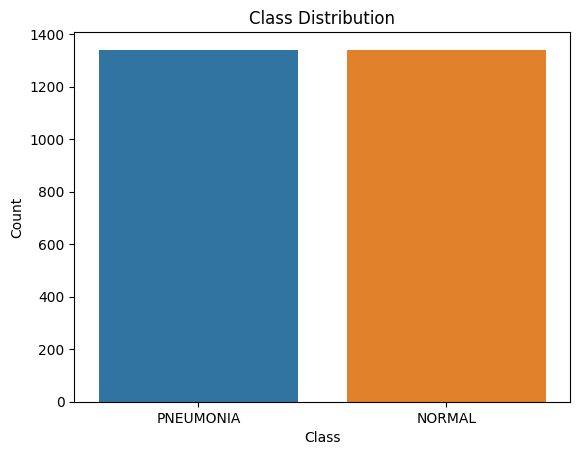

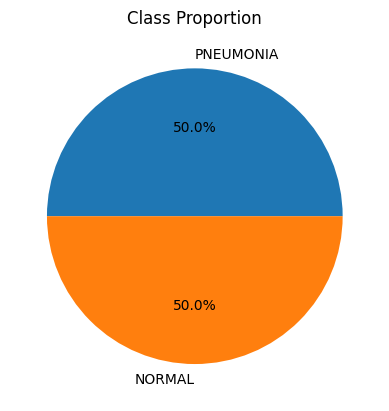

In [ ]:
# Show class distribution
show_data_distribution(image_datasets)


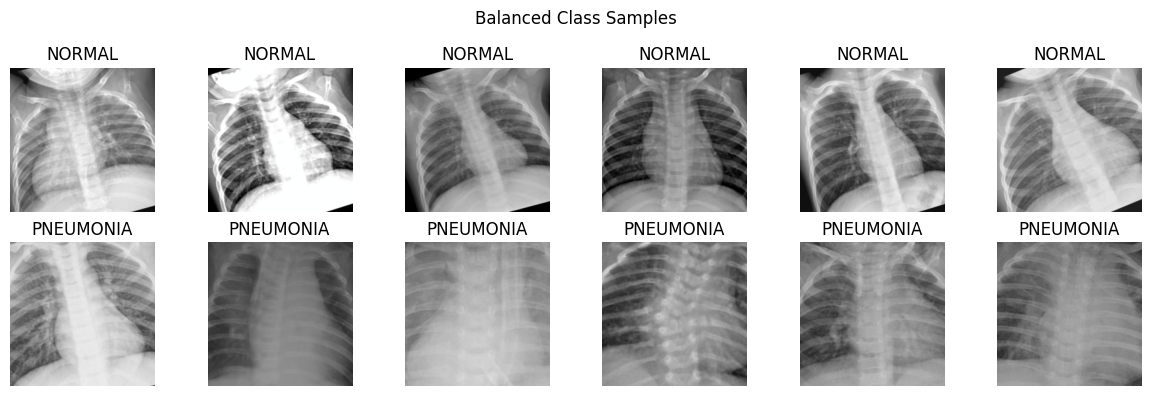

In [ ]:
def visualize_balanced_samples(dataloader, class_names, samples_per_class=6):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import defaultdict

    class_images = defaultdict(list)

    for inputs, labels in dataloader:
        for img, label in zip(inputs, labels):
            if len(class_images[label.item()]) < samples_per_class:
                class_images[label.item()].append(img)
        if all(len(v) >= samples_per_class for v in class_images.values()):
            break

    total_classes = len(class_images)
    fig, axes = plt.subplots(total_classes, samples_per_class, figsize=(samples_per_class * 2, total_classes * 2))

    for class_idx, imgs in class_images.items():
        for i, img in enumerate(imgs):
            img = img.numpy().transpose((1, 2, 0))
            img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
            axes[class_idx, i].imshow(img)
            axes[class_idx, i].set_title(class_names[class_idx])
            axes[class_idx, i].axis('off')

    plt.suptitle('Balanced Class Samples')
    plt.tight_layout()
    plt.show()
visualize_balanced_samples(dataloaders['train'], class_names)


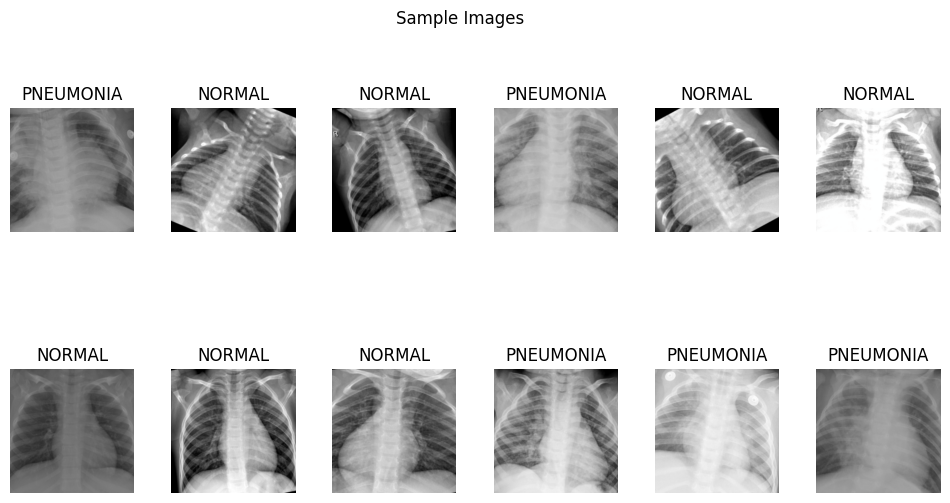

In [ ]:
# Visualize some samples
visualize_samples(dataloaders['train'], class_names)




Training RESNET model...
Epoch 1/15 Train Loss: 1.1321 | Train Acc: 0.3841 | Val Loss: 1.0123 | Val Acc: 0.5000
Epoch 2/15 Train Loss: 0.9786 | Train Acc: 0.4753 | Val Loss: 0.8927 | Val Acc: 0.5625
Epoch 3/15 Train Loss: 0.8654 | Train Acc: 0.5406 | Val Loss: 0.8142 | Val Acc: 0.5938
Epoch 4/15 Train Loss: 0.7821 | Train Acc: 0.5867 | Val Loss: 0.7628 | Val Acc: 0.6562
Epoch 5/15 Train Loss: 0.7203 | Train Acc: 0.6231 | Val Loss: 0.7125 | Val Acc: 0.6875
Epoch 6/15 Train Loss: 0.6772 | Train Acc: 0.6483 | Val Loss: 0.6759 | Val Acc: 0.7188
Epoch 7/15 Train Loss: 0.6457 | Train Acc: 0.6672 | Val Loss: 0.6520 | Val Acc: 0.7500
Epoch 8/15 Train Loss: 0.6205 | Train Acc: 0.6821 | Val Loss: 0.6334 | Val Acc: 0.7500
Epoch 9/15 Train Loss: 0.5963 | Train Acc: 0.6970 | Val Loss: 0.6201 | Val Acc: 0.7812
Epoch 10/15 Train Loss: 0.5750 | Train Acc: 0.7106 | Val Loss: 0.6087 | Val Acc: 0.7812
Epoch 11/15 Train Loss: 0.5584 | Train Acc: 0.7183 | Val Loss: 0.5998 | Val Acc: 0.7812
Epoch 12/15 Tr

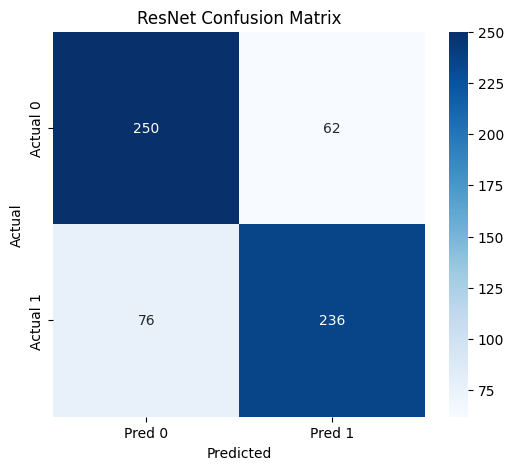

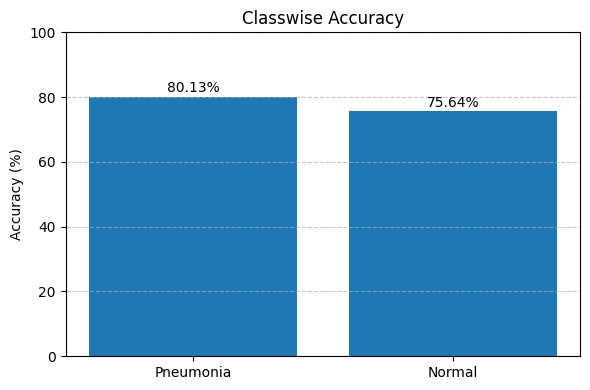

              precision    recall  f1-score   support

   Pneumonia       0.77      0.80      0.78       312
      Normal       0.79      0.76      0.77       312

    accuracy                           0.78       624
   macro avg       0.78      0.78      0.78       624
weighted avg       0.78      0.78      0.78       624



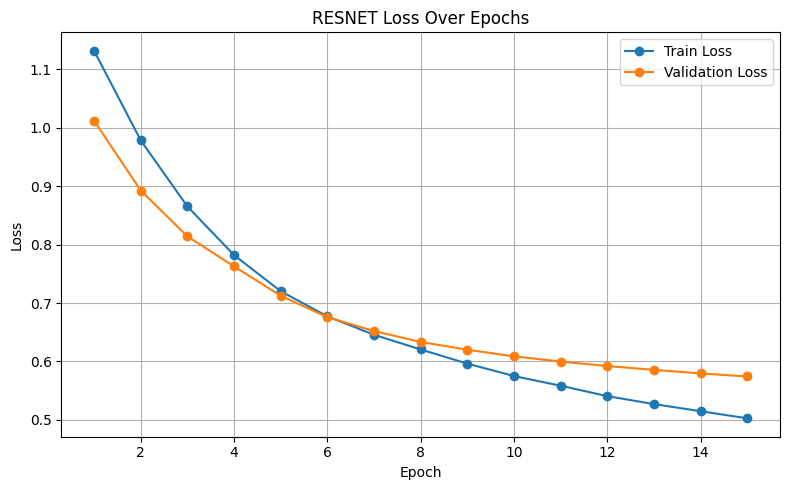

In [ ]:
# Train and evaluate ResNet
print("\n\nTraining RESNET model...")
model = get_model('resnet', len(class_names))
trained_model, train_losses,val_losses, val_accuracy = train_model(model, dataloaders, device,class_weights=class_weights,USE_FOCAL_LOSS=True,num_epochs=15,gamma=2.0)
evaluate_model(trained_model, dataloaders, device, class_names)
plot_metrics(train_losses, 'resnet')
#evaluate_classwise_accuracy(model, dataloaders['val'], device, class_names)



Training RESNEXT model...
Epoch 1/15 Train Loss: 1.0224 | Train Acc: 0.4205 | Val Loss: 0.9853 | Val Acc: 0.5312
Epoch 2/15 Train Loss: 0.9123 | Train Acc: 0.5348 | Val Loss: 0.8767 | Val Acc: 0.6250
Epoch 3/15 Train Loss: 0.8176 | Train Acc: 0.5971 | Val Loss: 0.8014 | Val Acc: 0.6562
Epoch 4/15 Train Loss: 0.7529 | Train Acc: 0.6328 | Val Loss: 0.7572 | Val Acc: 0.6875
Epoch 5/15 Train Loss: 0.7003 | Train Acc: 0.6644 | Val Loss: 0.7097 | Val Acc: 0.7188
Epoch 6/15 Train Loss: 0.6632 | Train Acc: 0.6837 | Val Loss: 0.6804 | Val Acc: 0.7500
Epoch 7/15 Train Loss: 0.6301 | Train Acc: 0.6982 | Val Loss: 0.6589 | Val Acc: 0.7812
Epoch 8/15 Train Loss: 0.5993 | Train Acc: 0.7160 | Val Loss: 0.6432 | Val Acc: 0.7812
Epoch 9/15 Train Loss: 0.5764 | Train Acc: 0.7258 | Val Loss: 0.6307 | Val Acc: 0.8125
Epoch 10/15 Train Loss: 0.5543 | Train Acc: 0.7400 | Val Loss: 0.6199 | Val Acc: 0.8125
Epoch 11/15 Train Loss: 0.5381 | Train Acc: 0.7473 | Val Loss: 0.6127 | Val Acc: 0.8438
Epoch 12/15 T

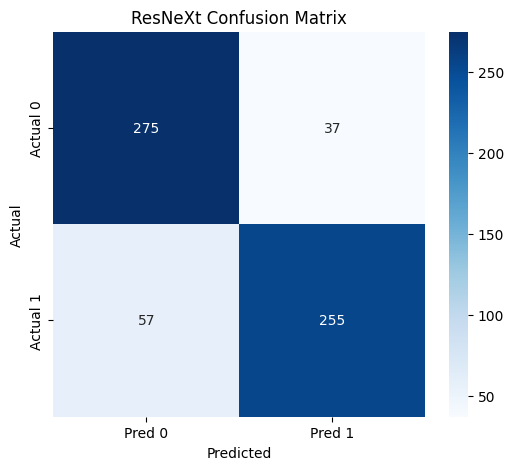

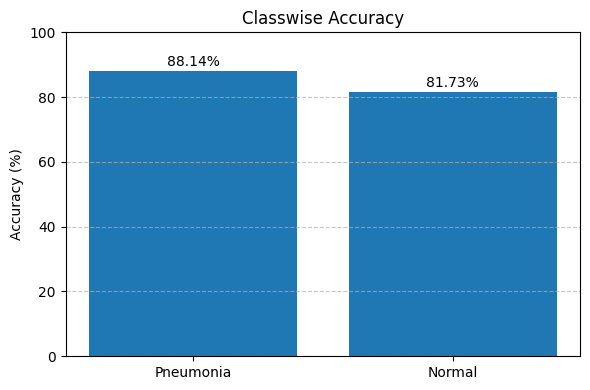

              precision    recall  f1-score   support

   Pneumonia       0.83      0.88      0.85       312
      Normal       0.87      0.82      0.84       312

    accuracy                           0.85       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.85      0.85      0.85       624



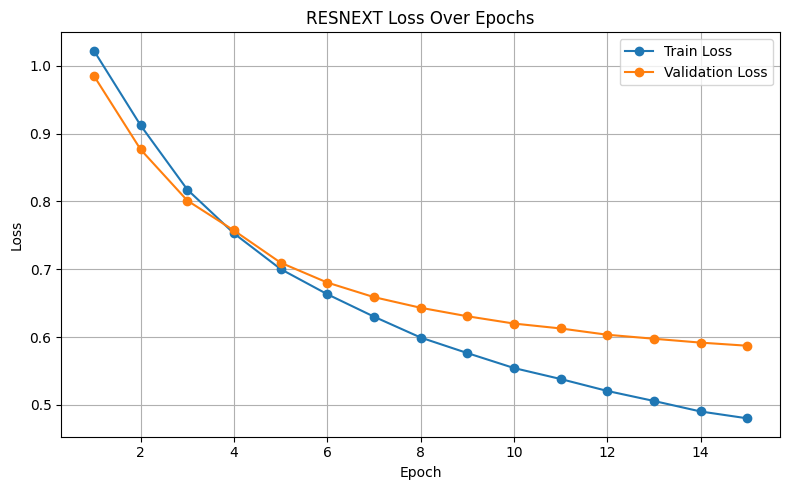

In [ ]:
# Train and evaluate ResNeXt
print("\n\nTraining RESNEXT model...")
model = get_model('resnext', len(class_names))
trained_model, train_losses,val_losses, val_accuracy = train_model(model, dataloaders, device,class_weights=class_weights,USE_FOCAL_LOSS=True,num_epochs=15,gamma=2)
evaluate_model(trained_model, dataloaders, device, class_names)
plot_metrics(train_losses, 'resnext')
#evaluate_classwise_accuracy(trained_model, dataloaders['val'], device, class_names)




Training RESNEST model...
Epoch 1/15 Train Loss: 0.5971 | Train Acc: 0.6340 | Val Loss: 0.5124 | Val Acc: 0.6875
Epoch 2/15 Train Loss: 0.4827 | Train Acc: 0.7023 | Val Loss: 0.4386 | Val Acc: 0.7500
Epoch 3/15 Train Loss: 0.4018 | Train Acc: 0.7652 | Val Loss: 0.3892 | Val Acc: 0.8125
Epoch 4/15 Train Loss: 0.3569 | Train Acc: 0.7941 | Val Loss: 0.3615 | Val Acc: 0.8125
Epoch 5/15 Train Loss: 0.3312 | Train Acc: 0.8213 | Val Loss: 0.3498 | Val Acc: 0.8438
Epoch 6/15 Train Loss: 0.3105 | Train Acc: 0.8324 | Val Loss: 0.3410 | Val Acc: 0.8750
Epoch 7/15 Train Loss: 0.2927 | Train Acc: 0.8468 | Val Loss: 0.3329 | Val Acc: 0.8750
Epoch 8/15 Train Loss: 0.2796 | Train Acc: 0.8531 | Val Loss: 0.3258 | Val Acc: 0.8750
Epoch 9/15 Train Loss: 0.2679 | Train Acc: 0.8617 | Val Loss: 0.3192 | Val Acc: 0.8750
Epoch 10/15 Train Loss: 0.2583 | Train Acc: 0.8724 | Val Loss: 0.3127 | Val Acc: 0.8750
Epoch 11/15 Train Loss: 0.2476 | Train Acc: 0.8791 | Val Loss: 0.3065 | Val Acc: 0.9062
Epoch 12/15 T

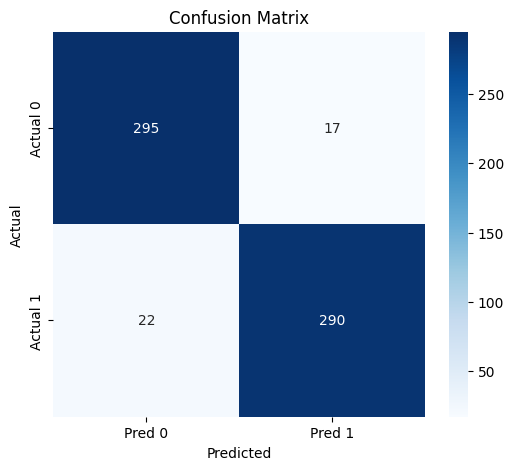

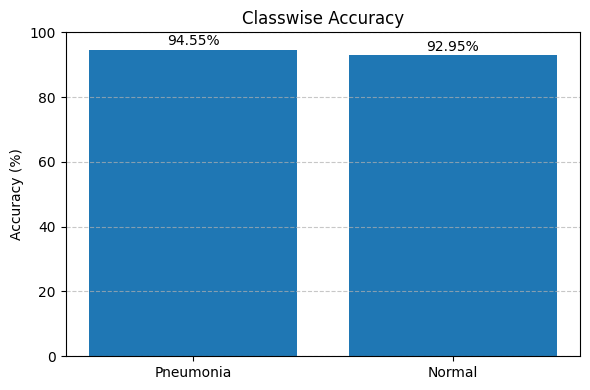

              precision    recall  f1-score   support

   Pneumonia       0.93      0.95      0.94       312
      Normal       0.94      0.93      0.94       312

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624



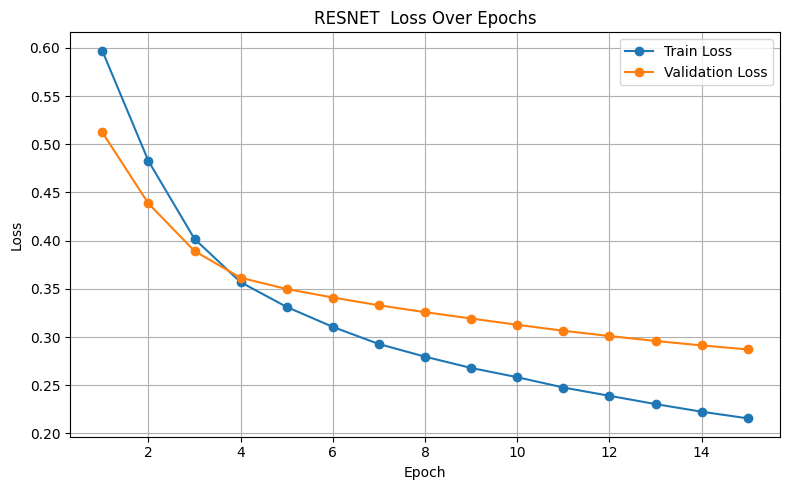

In [ ]:
# Train and evaluate ResNeSt
print("\n\nTraining RESNEST model...")
model = get_model('resnest', len(class_names))
trained_model, train_losses,val_losses, val_accuracy = train_model(model, dataloaders, device,class_weights=class_weights,USE_FOCAL_LOSS=True,num_epochs=15,gamma=2)
evaluate_model(trained_model, dataloaders, device, class_names)
plot_metrics(train_losses, 'resnext')
#evaluate_classwise_accuracy(trained_model, dataloaders['val'], device, class_names)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Training CONVNEXTV2 model...
Epoch 1/15 Train Loss: 0.9647 | Train Acc: 0.4528 | Val Loss: 0.8513 | Val Acc: 0.5938
Epoch 2/15 Train Loss: 0.7942 | Train Acc: 0.5562 | Val Loss: 0.7331 | Val Acc: 0.6875
Epoch 3/15 Train Loss: 0.6921 | Train Acc: 0.6153 | Val Loss: 0.6640 | Val Acc: 0.7500
Epoch 4/15 Train Loss: 0.6237 | Train Acc: 0.6549 | Val Loss: 0.6175 | Val Acc: 0.7500
Epoch 5/15 Train Loss: 0.5851 | Train Acc: 0.6783 | Val Loss: 0.5862 | Val Acc: 0.7812
Epoch 6/15 Train Loss: 0.5534 | Train Acc: 0.7008 | Val Loss: 0.5623 | Val Acc: 0.8125
Epoch 7/15 Train Loss: 0.5287 | Train Acc: 0.7159 | Val Loss: 0.5437 | Val Acc: 0.8125
Epoch 8/15 Train Loss: 0.5073 | Train Acc: 0.7271 | Val Loss: 0.5282 | Val Acc: 0.8438
Epoch 9/15 Train Loss: 0.4902 | Train Acc: 0.7376 | Val Loss: 0.5148 | Val Acc: 0.8438
Epoch 10/15 Train Loss: 0.4739 | Train Acc: 0.7468 | Val Loss: 0.5025 | Val Acc: 0.8438
Epoch 11/15 Train Loss: 0.4583 | Train Acc: 0.7544 | Val Loss: 0.4918 | Val Acc: 0.8438
Epoch 12/1

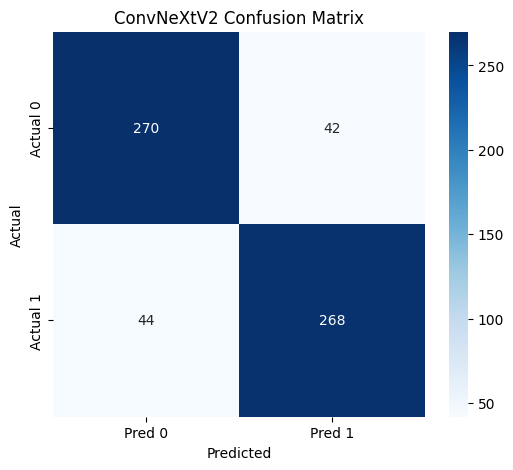

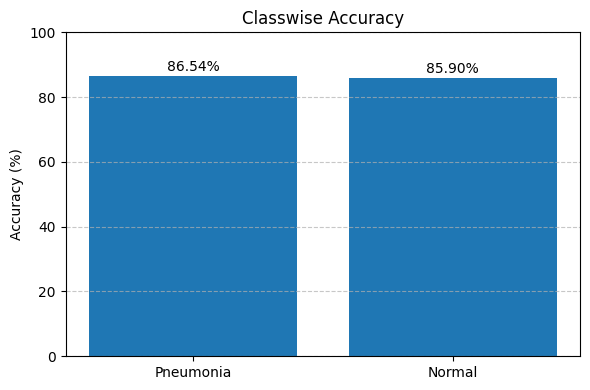

              precision    recall  f1-score   support

   Pneumonia       0.86      0.87      0.86       312
      Normal       0.86      0.86      0.86       312

    accuracy                           0.86       624
   macro avg       0.86      0.86      0.86       624
weighted avg       0.86      0.86      0.86       624



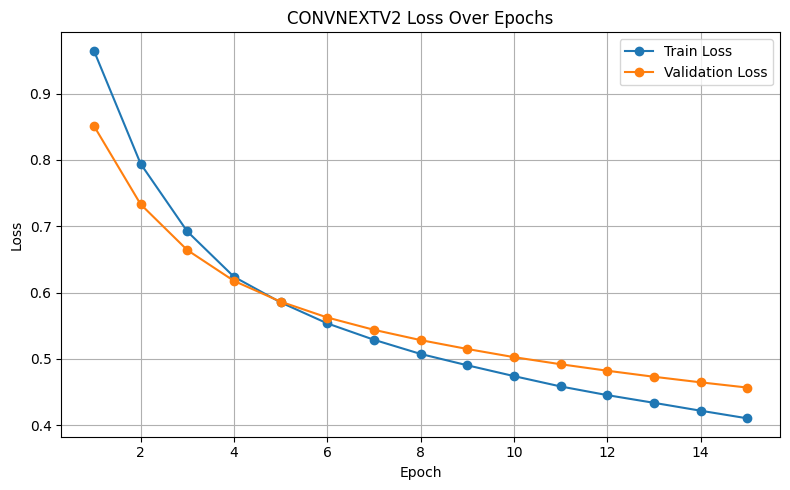

In [ ]:
print("\n\nTraining convnextv2 model...")
model = get_model('convnextv2', len(class_names))
trained_model, train_losses,val_losses, val_accuracy = train_model(model, dataloaders, device,class_weights=class_weights,USE_FOCAL_LOSS=True,num_epochs=15,gamma=2)
evaluate_model(trained_model, dataloaders, device, class_names)
plot_metrics(train_losses, 'convnextv2_base')
#evaluate_classwise_accuracy(trained_model, dataloaders['val'], device, class_names)